# Deep Network - Multi Layer Perceptron

---

## Setup

In [243]:
import sqlite3
import pandas as pd
import numpy as np
import subprocess

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve, 
    auc, 
    brier_score_loss, 
    classification_report
)
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import os

print("TensorFlow:", tf.__version__)

# Make sure we can open the db file
try:
    root = subprocess.check_output(
        ["git", "rev-parse", "--show-toplevel"],
        text=True,
    ).strip()
    os.chdir(root)
except Exception:
    while not (Path.cwd() / "data").exists() and Path.cwd() != Path.home():
        os.chdir("..")

print("Working directory:", Path.cwd())
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)

TensorFlow: 2.20.0
Working directory: /Users/ecasto/cs230-project


## Load labeled data routes

In [244]:
conn = sqlite3.connect("data/routes_scores.db")
df = pd.read_sql("SELECT * FROM routes;", conn)

df["counties"] = df["counties"].fillna("")
df["county_count"] = df["counties"].str.count(",").fillna(0).astype(int) + 1

print("Label distribution:\n", df["impacting_delivery"].value_counts(normalize=True))
print("Dataset shape:", df.shape)
df[["counties", "county_count"]].head()

Label distribution:
 impacting_delivery
0    0.76505
1    0.23495
Name: proportion, dtype: float64
Dataset shape: (20000, 5)


,counties,county_count
0,"NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,SAN ...",4
1,"SANTA YNEZ MOUNTAINS EASTERN RANGE,SAN JOAQUIN...",5
2,SANTA LUCIA MOUNTAINS AND LOS PADRES NATIONAL ...,8
3,"HUMBOLDT,W CENTRAL S.J. VALLEY,SAN GORGONIO PA...",6
4,"TRINITY,Carquinez Strait and Delta,ORANGE COUN...",10


## Helper functions

In [245]:
# Splits
def make_splits(df, feature_cols, target_col="impacting_delivery"):
    """
    Returns train/val/test splits given selected feature columns.
    Stratified by label.
    """
    df_clean = df.copy()
    
    # Basic missing handling
    for col in feature_cols:
        if df_clean[col].dtype == "O": 
            df_clean[col] = df_clean[col].fillna("Unknown")
        else:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    train, test = train_test_split(
        df_clean,
        test_size=0.15,
        random_state=42,
        stratify=df_clean[target_col]
    )
    train, val = train_test_split(
        train,
        test_size=0.1765,
        random_state=42,
        stratify=train[target_col]
    )
    
    X_train = train[feature_cols]
    y_train = train[target_col]
    X_val   = val[feature_cols]
    y_val   = val[target_col]
    X_test  = test[feature_cols]
    y_test  = test[target_col]
    
    print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
    print("Label distribution (train):")
    print(y_train.value_counts(normalize=True))
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Preprocessing + tf.data helper

In [246]:
def build_preprocessor(numeric_features, categorical_features):
    numeric_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    return preprocessor


In [247]:
def build_bow_preprocessor(text_feature, numeric_features):
    to_1d = FunctionTransformer(lambda x: x.squeeze(), validate=False)

    county_bow = Pipeline(steps=[
        ("to_1d", to_1d),
        ("vec", CountVectorizer(
            tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
            lowercase=False,
            min_df=5,
        )),
    ])

    numeric_pipe = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("county_bow", county_bow, [text_feature]),
            ("num", numeric_pipe, numeric_features),
        ]
    )

    return preprocessor


In [248]:
def preprocess_and_to_arrays(preprocessor, X_train, X_val, X_test):
    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc   = preprocessor.transform(X_val)
    X_test_proc  = preprocessor.transform(X_test)

    # Many sklearn transformers return sparse matrices -> convert to dense
    if hasattr(X_train_proc, "toarray"):
        X_train_proc = X_train_proc.toarray()
        X_val_proc   = X_val_proc.toarray()
        X_test_proc  = X_test_proc.toarray()

    print("Processed feature dim:", X_train_proc.shape[1])
    return X_train_proc, X_val_proc, X_test_proc


In [249]:
def make_tf_datasets(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train.values))
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val.values))
    test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test.values))
    
    train_ds = train_ds.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

MLP model builder

In [250]:
def build_mlp(input_dim, l2_reg=1e-4, dropout_rate=0.3):
    model = Sequential([
        Dense(64, activation="relu", kernel_regularizer=l2(l2_reg), input_shape=(input_dim,)),
        Dense(32, activation="relu", kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="AUPRC", curve="PR")
        ]
    )
    
    model.summary()
    return model


Training + evaluation helper

In [251]:
def train_and_evaluate_mlp(
    X_train_proc, y_train,
    X_val_proc, y_val,
    X_test_proc, y_test,
    tag="with_score"
):
    # Build datasets
    train_ds, val_ds, test_ds = make_tf_datasets(
        X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test, batch_size=32
    )
    
    # Build model
    model = build_mlp(input_dim=X_train_proc.shape[1])
    
    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Plot training curves
    os.makedirs("results", exist_ok=True)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.title(f"Loss Curves ({tag})")
    plt.savefig(f"results/mlp_loss_{tag}.png", dpi=150)
    plt.close()
    
    # Evaluate
    results = model.evaluate(test_ds, return_dict=True)
    print(f"\nTest metrics ({tag}):", results)
    
    # Choose threshold on validation set
    val_probs = model.predict(X_val_proc).ravel()
    prec_v, rec_v, thr_v = precision_recall_curve(y_val, val_probs)

    f1_v = (2 * prec_v * rec_v) / (prec_v + rec_v + 1e-12)
    best_idx = np.nanargmax(f1_v)
    best_thr = thr_v[best_idx] if best_idx < len(thr_v) else 0.5

    print(f"Best validation threshold (F1-optimal) = {best_thr:.3f}")

    # Predict probabilities on test set
    probs = model.predict(X_test_proc).ravel()

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    auc_pr = auc(recall, precision)
    brier  = brier_score_loss(y_test, probs)

    print(f"AUPRC ({tag}):", auc_pr)
    print(f"Brier Score ({tag}):", brier)
    print("\nClassification Report (threshold from val):\n")
    y_pred_test = (probs >= best_thr).astype(int)
    print(classification_report(y_test, y_pred_test))

    # Save PR curve
    plt.plot(recall, precision)
    plt.title(f"Precision-Recall Curve ({tag}) AUC={auc_pr:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.savefig(f"results/pr_curve_mlp_{tag}.png", dpi=150)
    plt.close()
    
    # Save metrics
    metrics = results.copy()
    metrics["AUPRC_curve"] = auc_pr
    metrics["brier_score"] = brier
    metrics["best_threshold"] = best_thr
    pd.DataFrame([metrics]).to_csv(f"results/mlp_metrics_{tag}.csv", index=False)
    
    # Save model
    os.makedirs("models", exist_ok=True)
    model.save(f"models/mlp_{tag}.keras")
    
    return model, metrics

## Experiment 1 — With impact_score (Model A)

In [252]:
# Features for Model A (with impact_score)
numeric_features_A = ["impact_score"]
categorical_features_A = ["counties"]
feature_cols_A = numeric_features_A + categorical_features_A

X_train_A, y_train_A, X_val_A, y_val_A, X_test_A, y_test_A = make_splits(
    df, feature_cols_A, target_col="impacting_delivery"
)

preprocessor_A = build_preprocessor(numeric_features_A, categorical_features_A)
X_train_proc_A, X_val_proc_A, X_test_proc_A = preprocess_and_to_arrays(
    preprocessor_A, X_train_A, X_val_A, X_test_A
)


Train: (13999, 2) Val: (3001, 2) Test: (3000, 2)
Label distribution (train):
impacting_delivery
0    0.765055
1    0.234945
Name: proportion, dtype: float64
Processed feature dim: 14000


In [253]:
# Train & evaluate MLP (with impact_score)
mlp_with_score, metrics_with_score = train_and_evaluate_mlp(
    X_train_proc_A, y_train_A,
    X_val_proc_A, y_val_A,
    X_test_proc_A, y_test_A,
    tag="with_score"
)

/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_153 (Dense)               │ (None, 64)             │       896,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 898,177 (3.43 MB)

 Trainable params: 898,177 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUPRC: 0.9870 - loss: 0.1707 - precision: 0.9631 - recall: 0.9137 - val_AUPRC: 1.0000 - val_loss: 0.0386 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.0223 - precision: 0.9970 - recall: 0.9979 - val_AUPRC: 1.0000 - val_loss: 0.0320 - val_precision: 1.0000 - val_recall: 0.9702
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.0132 - precision: 1.0000 - recall: 0.9997 - val_AUPRC: 1.0000 - val_loss: 0.0266 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.0112 - precision: 1.0000 - recall: 1.0000 - val_AUPRC: 1.0000 - val_loss: 0.0245 - val_precision: 0.9902 - val_recall: 1.0000
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.0105 - precision: 1.0000 - recall: 1.0000 - val_AUPRC: 1.0000 - val_loss: 0.0314 - val_precision: 0.9501 -

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


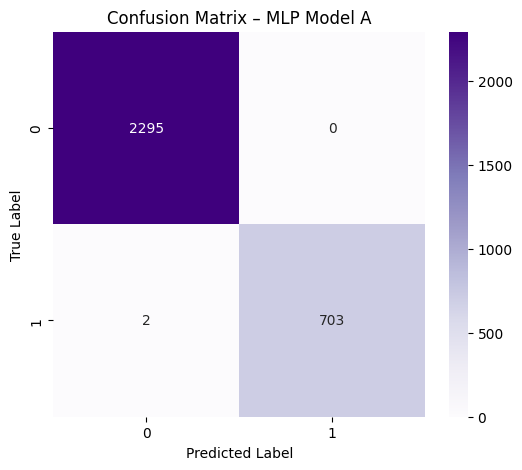

In [254]:
# Confusion Matrix for Model A
from sklearn.metrics import confusion_matrix
import seaborn as sns

mlp_probs = mlp_with_score.predict(X_test_proc_A).ravel()
mlp_preds = (mlp_probs >= 0.5).astype(int)

cm_mlp = confusion_matrix(y_test_A, mlp_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix – MLP Model A")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("results/cm_mlp_with_score.png", dpi=150)
plt.show()

## Experiment 2 — Without impact_score (Model B)

In [255]:
# Features for Model B (without impact_score)
numeric_features_B = []   # none
categorical_features_B = ["counties"]
feature_cols_B = categorical_features_B

X_train_B, y_train_B, X_val_B, y_val_B, X_test_B, y_test_B = make_splits(
    df, feature_cols_B, target_col="impacting_delivery"
)

preprocessor_B = build_preprocessor(numeric_features_B, categorical_features_B)
X_train_proc_B, X_val_proc_B, X_test_proc_B = preprocess_and_to_arrays(
    preprocessor_B, X_train_B, X_val_B, X_test_B
)


Train: (13999, 1) Val: (3001, 1) Test: (3000, 1)
Label distribution (train):
impacting_delivery
0    0.765055
1    0.234945
Name: proportion, dtype: float64
Processed feature dim: 13999


In [256]:
# Train & evaluate MLP (without impact_score)
mlp_no_score, metrics_no_score = train_and_evaluate_mlp(
    X_train_proc_B, y_train_B,
    X_val_proc_B, y_val_B,
    X_test_proc_B, y_test_B,
    tag="no_score"
)


/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_156 (Dense)               │ (None, 64)             │       896,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 898,113 (3.43 MB)

 Trainable params: 898,113 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUPRC: 0.2371 - loss: 0.5632 - precision: 0.1481 - recall: 0.0012 - val_AUPRC: 0.2349 - val_loss: 0.5528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 0.9196 - loss: 0.4300 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUPRC: 0.2349 - val_loss: 0.5796 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.1920 - precision: 1.0000 - recall: 0.9149 - val_AUPRC: 0.2349 - val_loss: 0.6292 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.1416 - precision: 1.0000 - recall: 0.9957 - val_AUPRC: 0.2349 - val_loss: 0.6424 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUPRC: 1.0000 - loss: 0.1160 - precision: 1.0000 - recall: 0.9994 - val_AUPRC: 0.2349 - va

/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


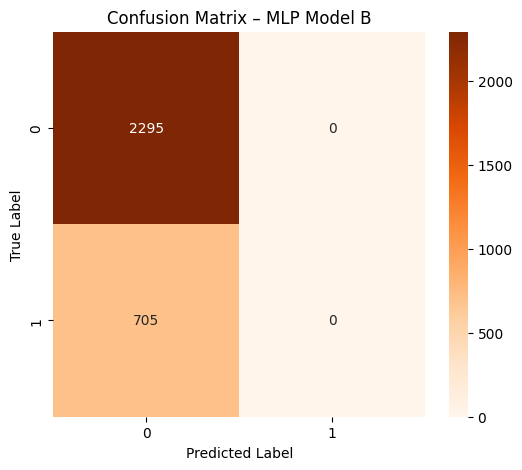

In [257]:
# Confusion Matrix for Model B
mlp_probs_no = mlp_no_score.predict(X_test_proc_B).ravel()
mlp_preds_no = (mlp_probs_no >= 0.5).astype(int)

cm_mlp_no = confusion_matrix(y_test_B, mlp_preds_no)

plt.figure(figsize=(6,5))
sns.heatmap(cm_mlp_no, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix – MLP Model B")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("results/cm_mlp_no_score.png", dpi=150)
plt.show()

## Experiment 3 - Multi-county representation, no impact_score (Model C)

In [258]:
text_feature_bow = "counties"
numeric_features_bow = ["county_count"]
feature_cols_bow = [text_feature_bow] + numeric_features_bow

X_train_bow, y_train_bow, X_val_bow, y_val_bow, X_test_bow, y_test_bow = make_splits(
    df,
    feature_cols_bow,
    target_col="impacting_delivery"
)

preprocessor_bow = build_bow_preprocessor(
    text_feature=text_feature_bow,
    numeric_features=numeric_features_bow,
)

X_train_proc_bow, X_val_proc_bow, X_test_proc_bow = preprocess_and_to_arrays(
    preprocessor_bow,
    X_train_bow,
    X_val_bow,
    X_test_bow,
)

Train: (13999, 2) Val: (3001, 2) Test: (3000, 2)
Label distribution (train):
impacting_delivery
0    0.765055
1    0.234945
Name: proportion, dtype: float64
Processed feature dim: 313


/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [259]:
mlp_bow, metrics_bow = train_and_evaluate_mlp(
    X_train_proc_bow, y_train_bow,
    X_val_proc_bow, y_val_bow,
    X_test_proc_bow, y_test_bow,
    tag="bow_counties"
)

/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_159 (Dense)               │ (None, 64)             │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUPRC: 0.7554 - loss: 0.3526 - precision: 0.8561 - recall: 0.4360 - val_AUPRC: 0.9734 - val_loss: 0.1398 - val_precision: 0.9528 - val_recall: 0.8298
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - AUPRC: 0.9766 - loss: 0.1206 - precision: 0.9350 - recall: 0.8878 - val_AUPRC: 0.9835 - val_loss: 0.1063 - val_precision: 0.9598 - val_recall: 0.8794
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - AUPRC: 0.9904 - loss: 0.0848 - precision: 0.9566 - recall: 0.9380 - val_AUPRC: 0.9843 - val_loss: 0.1065 - val_precision: 0.8895 - val_recall: 0.9702
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - AUPRC: 0.9954 - loss: 0.0664 - precision: 0.9699 - recall: 0.9599 - val_AUPRC: 0.9885 - val_loss: 0.0841 - val_precision: 0.9660 - val_recall: 0.9262
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - AUPRC: 0.9975 - loss: 0.0552 - precision: 0.9786 - recall: 0.9726 - val_AUPRC: 0.9860 - val_loss: 0.0935 - val_precision: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step


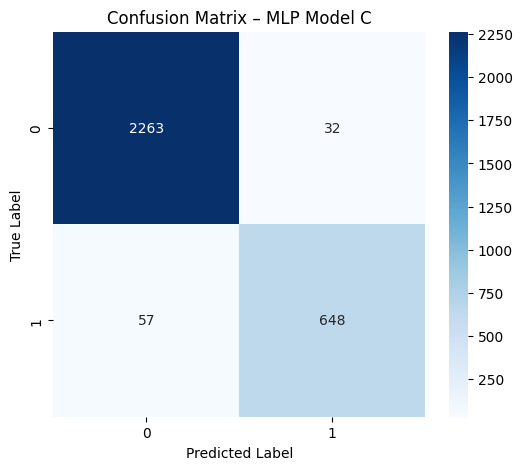

In [260]:
# Confusion Matrix for Model C
mlp_probs_bow = mlp_bow.predict(X_test_proc_bow).ravel()
mlp_preds_bow = (mlp_probs_bow >= 0.5).astype(int)

cm_mlp_bow = confusion_matrix(y_test_bow, mlp_preds_bow)

plt.figure(figsize=(6,5))
sns.heatmap(cm_mlp_bow, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – MLP Model C")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("results/cm_mlp_c.png", dpi=150)
plt.show()

Identify the routes the model got most wrong

In [261]:
results_df = X_test_bow.copy()
results_df["y_true"] = y_test_bow.values
results_df["y_prob"] = mlp_probs_bow
results_df["y_pred"] = (results_df["y_prob"] >= 0.5).astype(int)

# FALSE NEGATIVES
worst_fn = results_df[(results_df.y_true == 1) & (results_df.y_pred == 0)] \
    .sort_values("y_prob") \
    .head(10)

# FALSE POSITIVES
worst_fp = results_df[(results_df.y_true == 0) & (results_df.y_pred == 1)] \
    .sort_values("y_prob", ascending=False) \
    .head(10)

worst_fn.to_csv("results/mlp_worst_fn.csv", index=False)
worst_fp.to_csv("results/mlp_worst_fp.csv", index=False)

worst_fn, worst_fp

(                                                counties  county_count  \
 12696  Central Sacramento Valley,E CENTRAL S.J. VALLE...            10   
 17480  SANTA BARBARA COUNTY MOUNTAINS,KERN COUNTY DES...             9   
 160    SAN DIEGO COUNTY DESERTS,Northern Sacramento V...             6   
 5299   EASTERN KERN COUNTY,FRAZIER MOUNTAIN COMMUNITI...             7   
 4900   CENTRAL VENTURA COUNTY VALLEYS,EST SANTA MONIC...             8   
 2501   Eastern Mojave Desert,SANTA LUCIA MOUNTAINS AN...             5   
 7437   TEHACHAPI,SANTA CRUZ,SANTA MONICA MOUNTAINS RE...             7   
 6246   IMPERIAL COUNTY SOUTHEAST,SANTA YNEZ VALLEY,CA...             9   
 16863  TULARE,LOS BANOS-DOS PALOS,NORTHWESTERN MENDOC...             6   
 1857   IMPERIAL COUNTY SOUTHWEST,KERN,CENTRAL SIERRA ...            10   
 
        y_true    y_prob  y_pred  
 12696       1  0.000363       0  
 17480       1  0.012906       0  
 160         1  0.014882       0  
 5299        1  0.020509       0 

County-level misclassification

In [262]:
def explode_counties(df):
    df_copy = df.copy()
    df_copy["county_list"] = df_copy["counties"].str.split(",")
    return df_copy.explode("county_list")

expanded = explode_counties(results_df)

expanded["is_wrong"] = (expanded.y_true != expanded.y_pred).astype(int)

county_error = expanded.groupby("county_list")["is_wrong"].mean().sort_values(ascending=False)

county_error.head(20)

county_list
SANTA CRUZ                                              0.092308
San Bernardino County Mountains                         0.087719
WHITE MOUNTAINS OF INYO COUNTY                          0.087719
VENTURA COUNTY INLAND COAST                             0.086207
Southeast Kern County Desert                            0.085714
SAN JOAQUIN                                             0.084746
SANTA LUCIA MOUNTAINS AND LOS PADRES NATIONAL FOREST    0.084746
SAN LUIS OBISPO COUNTY BEACHES                          0.082192
Kern County Mountains                                   0.080645
RIVERSIDE                                               0.078125
EST SANTA MONICA MOUNTAINS                              0.075472
FRESNO                                                  0.075472
SOUTH END SIERRA FOOTHILLS                              0.074074
South Sierra Foothills                                  0.071429
STANISLAUS                                              0.071429
FRESNO - TULA

## Comparison table

In [263]:
comparison = pd.DataFrame([
    {"model": "MLP_with_score", "AUPRC": metrics_with_score["AUPRC_curve"], "brier": metrics_with_score["brier_score"]},
    {"model": "MLP_no_score",   "AUPRC": metrics_no_score["AUPRC_curve"],   "brier": metrics_no_score["brier_score"]},
    {"model": "MLP_no_score_bow_counties", "AUPRC": metrics_bow["AUPRC_curve"], "brier":  metrics_bow["brier_score"],
    },
])

comparison


,model,AUPRC,brier
0,MLP_with_score,1.000000,0.001207
1,MLP_no_score,0.617500,0.179863
2,MLP_no_score_bow_counties,0.987179,0.021696


In [264]:
#Save results for error analysis
np.save("results/mlp_with_score_probs.npy", mlp_probs)
np.save("results/mlp_with_score_y_test.npy", y_test_A.values)

np.save("results/mlp_no_score_probs.npy", mlp_probs_no)
np.save("results/mlp_no_score_y_test.npy", y_test_B.values)

np.save("results/mlp_bow_probs.npy", mlp_probs_bow)
np.save("results/mlp_bow_y_test.npy", y_test_bow.values)


## Hyperparameter testing

Dropout:

In [265]:
from tensorflow.keras.callbacks import EarlyStopping

#build datasets
Xtr = X_train_proc_bow
Xv  = X_val_proc_bow
Xt  = X_test_proc_bow
ytr = y_train_bow
yv  = y_val_bow
yt  = y_test_bow

train_ds, val_ds, test_ds = make_tf_datasets(
    Xtr, ytr, Xv, yv, Xt, yt, batch_size=32
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

dropouts = [0.1, 0.3, 0.5]
dropout_results = []

for d in dropouts:    
    model = build_mlp(input_dim=Xtr.shape[1], dropout_rate=d)
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[early_stop],
        verbose=0
    )

    best_val_loss = min(history.history["val_loss"])
    
    dropout_results.append({"dropout": d, "val_loss": best_val_loss})

pd.DataFrame(dropout_results)

/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_162 (Dense)               │ (None, 64)             │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_165 (Dense)               │ (None, 64)             │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 64)             │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

,dropout,val_loss
0,0.1,0.092168
1,0.3,0.083642
2,0.5,0.084962


Learning Rate:

In [266]:
learning_rates = [1e-4, 3e-4, 1e-3]
lr_results = []

for lr in learning_rates:
    # Build new model with this LR
    model = Sequential([
        Dense(64, activation="relu", kernel_regularizer=l2(1e-4), input_shape=(Xtr.shape[1],)),
        Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.1),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="AUPRC", curve="PR")
        ]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[early_stop],
        verbose=0
    )

    best_val_loss = min(history.history["val_loss"])
    
    lr_results.append({"learning_rate": lr, "val_loss": best_val_loss})

pd.DataFrame(lr_results)


/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,learning_rate,val_loss
0,0.0001,0.233122
1,0.0003,0.090216
2,0.0010,0.085898
